# Week 4 BBC News Classification Kaggle Mini-Project

## Import libraries and data
Importing libraries

In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
from collections import Counter

from itertools import permutations

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')


## Exploratory Data Analysis (EDA)

In [5]:
print("\nTRAIN INFO\n")
print(train.info())
train.head()


TRAIN INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [6]:

display(test.info())
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


None

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


### Visualization

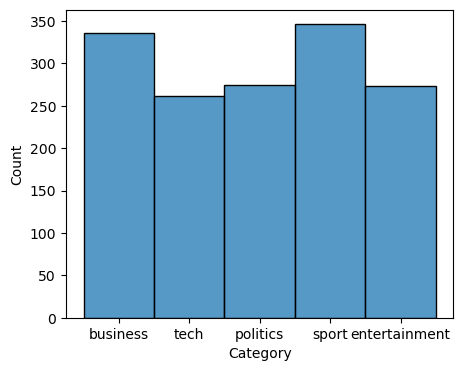

In [8]:
plt.figure(figsize=(5, 4))
sns.histplot(train, x='Category');

In [9]:
category_counts = train.Category.value_counts()
display(category_counts)

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

In [10]:
majority_class = category_counts.loc['sport']
minority_class = category_counts.loc['tech']
imbalance_ratio = majority_class / minority_class
display(imbalance_ratio)

1.3256704980842913

### What is the Imbalance Ratio?

The **imbalance ratio** measures class imbalance in a dataset by comparing the number of samples in the majority class to those in the minority class. It's calculated as:

$$
  \text{Imbalance Ratio} = \frac{N_{\text{majority}}}{N_{\text{minority}}}
$$

### Example Calculation

If Class 0 has 900 samples and Class 1 has 100 samples, the imbalance ratio is:

$$
  \text{Imbalance Ratio} = \frac{900}{100} = 9
$$

### Good vs. Bad Imbalance Ratios

- **Close to 1 (Good)**: Indicates a balanced dataset.
- **3 to 10 (Moderate)**: Suggests some imbalance; may need minor adjustments.
- **Above 10 (Bad)**: Significant imbalance; requires corrective measures like resampling or using specialized algorithms.

### Importance of the Imbalance Ratio

Understanding the imbalance ratio helps:
- Assess the need for balancing techniques.
- Guide model selection and evaluation.
- Ensure fair and accurate predictions across all classes.

A good ratio is close to 1, while ratios above 10 often require intervention to improve model performance.

In [12]:
train_stats = train[['Text', 'Category']]
train_stats['word_count'] = train_stats.Text.apply(lambda x: len(x.split()))
train_stats[['Category', 'word_count']].groupby('Category').describe()

word_count                                                \
                   count        mean         std    min     25%    50%   
Category                                                                 
business           336.0  334.169643  133.527272  145.0  253.00  304.0   
entertainment      273.0  333.912088  203.887349  144.0  229.00  272.0   
politics           274.0  449.689781  258.836242   90.0  319.25  441.5   
sport              346.0  335.346821  185.443084  116.0  210.25  294.5   
tech               261.0  501.858238  211.672986  188.0  340.00  457.0   

                               
                  75%     max  
Category                       
business       391.25   902.0  
entertainment  380.00  2448.0  
politics       527.00  3345.0  
sport          412.75  1671.0  
tech           633.00  1549.0

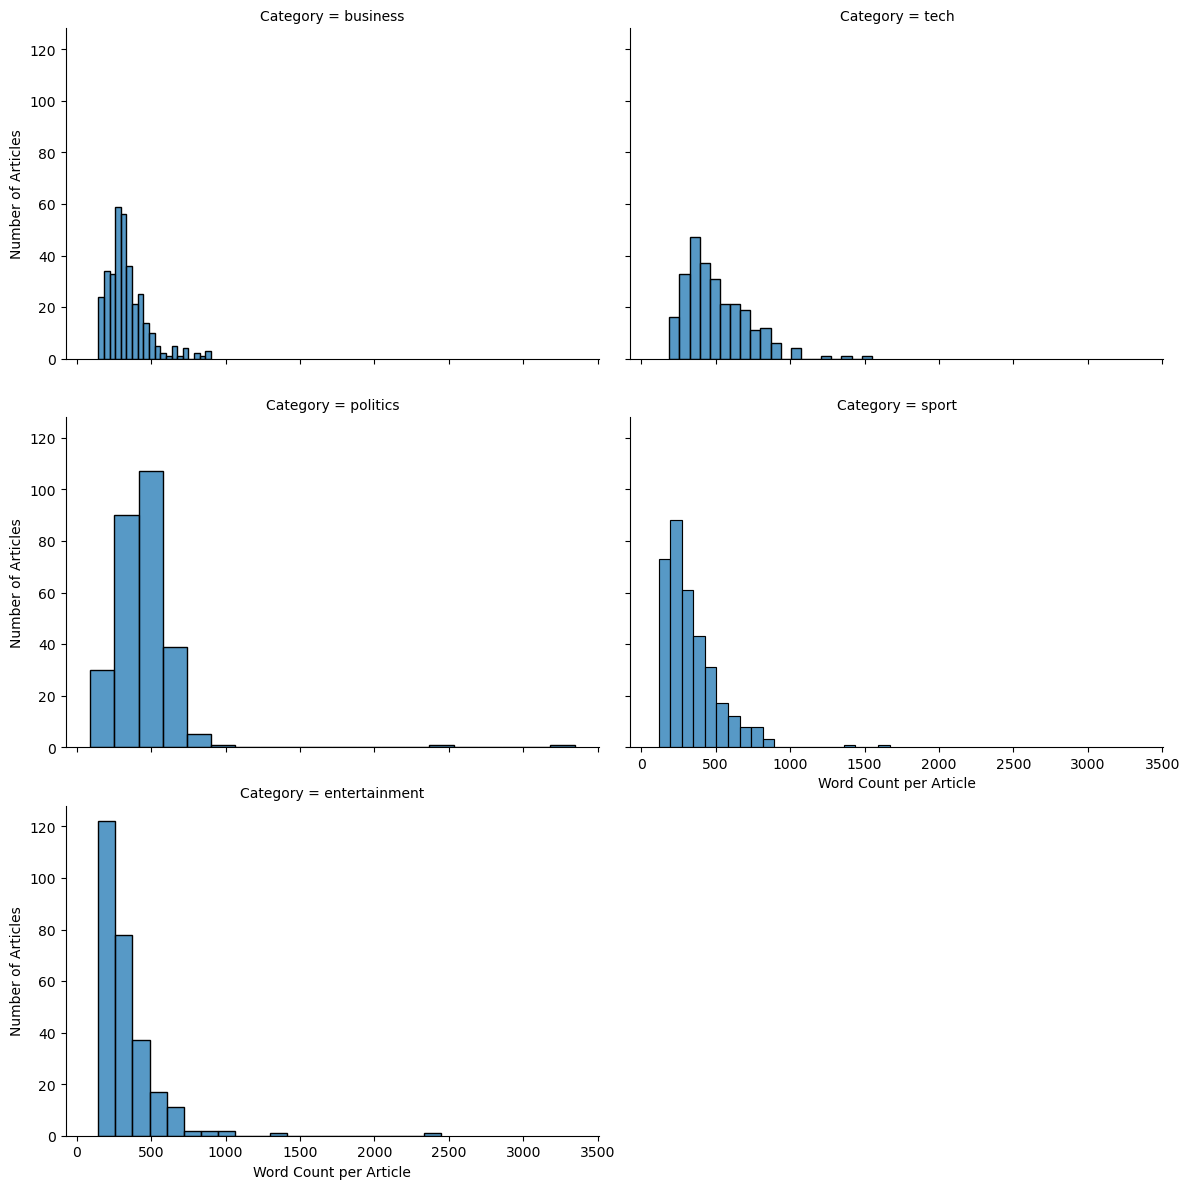

In [13]:
g = sns.FacetGrid(train_stats, col='Category', col_wrap=2, height=4, aspect=1.5)
g.map(sns.histplot, 'word_count', bins=20)
g.set_axis_labels('Word Count per Article', 'Number of Articles')
plt.show()

### Insights

1. **Dominance of Shorter Articles**: The majority of articles across all categories have word counts below 500. This indicates that shorter articles are common regardless of the topic, suggesting that the content in this dataset tends to be concise.

2. **Business and Politics Categories**: These two categories show a slightly higher concentration of articles with word counts closer to the 500-800 range compared to others. This could imply that business and politics topics often require more detailed explanations or analysis.

3. **Variation in Distribution**:
   - **Entertainment and Tech**: These categories seem to have more articles clustered around shorter word counts, indicating that these topics might be more straightforward or summarized.
   - **Politics**: The politics category has a wider spread, with articles stretching into higher word counts, suggesting that political articles can be more variable in length, possibly due to the complexity of the topics discussed.

4. **Outliers in Politics and Business**: A few articles in the politics and business categories have significantly higher word counts (e.g., around 2500-3500 words). These could be in-depth reports, feature articles, or special analyses that go into much greater detail than typical content.

5. **Overlap Across Categories**: There is a significant overlap in word count distributions across all categories, meaning that word count alone might not be a strong differentiator between these categories. Other features might be needed for better classification if this was a task.

6. **Potential for Content Segmentation**: Given the variation in word counts within certain categories like politics and business, there might be opportunities to segment content into sub-categories based on article length, such as brief news updates versus in-depth features.

These insights suggest that while word count is an important characteristic, it interacts with content type differently across categories, influencing the overall presentation and possibly the reader's engagement with the material.

## Data Quality

1. **Missing Values**: Checking for missing values in both the train and test data helps identify gaps in the dataset that may need to be addressed through imputation or removal, which is crucial for building accurate models.

2. **Unique Values**: Counting the unique values in the train data (`train.nunique()`) helps identify the diversity of data in each column, revealing potential categorical variables and aiding in feature selection and preprocessing decisioeling.

In [16]:
# Check for missing values
print("\nMissing values in Train Data:")
display(train.isnull().sum())

print("\nMissing values in Test Data:")
display(test.isnull().sum())

print("\nIdentifying Categorical Features:")
display(train.nunique())


Missing values in Train Data:


ArticleId    0
Text         0
Category     0
dtype: int64


Missing values in Test Data:


ArticleId    0
Text         0
dtype: int64


Identifying Categorical Features:


ArticleId    1490
Text         1440
Category        5
dtype: int64

In [17]:
label_names = train.Category.unique().tolist()
label_names
mapping = dict(zip(label_names, list(range(5))))
mapping
train['labels'] = [mapping[c] for c in train.Category]
train.tail()
y = train.labels.tolist()

## Data Cleaning

### Identifying duplicate articles based on the 'Text' column

In [20]:
duplicates = train[train.duplicated(subset='Text', keep=False)]
duplicates_sorted = duplicates.sort_values(by='Text').reset_index(drop=True)
display(duplicates_sorted)

,ArticleId,Text,Category,labels
0,1326,ask jeeves joins web log market ask jeeves has...,tech,1
1,1098,ask jeeves joins web log market ask jeeves has...,tech,1
2,1042,aviator creator in oscars snub the man who s...,entertainment,4
3,374,aviator creator in oscars snub the man who s...,entertainment,4
4,1847,blind student hears in colour a blind studen...,tech,1
...,...,...,...,...
95,789,virus poses as christmas e-mail security firms...,tech,1
96,957,web radio takes spanish rap global spin the ra...,tech,1
97,110,web radio takes spanish rap global spin the ra...,tech,1
98,2017,what high-definition will do to dvds first it ...,tech,1


In [21]:
train = train.drop_duplicates(subset='Text', keep='first').reset_index(drop=True)
train.nunique()

ArticleId    1440
Text         1440
Category        5
labels          5
dtype: int64

Now ArticleId count matches Text count

### Removing stop words

In [24]:
# Function to clean text
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

# Apply the cleaning function to the 'Text' column in both datasets
train['cleaned_text'] = train['Text'].apply(clean_text)
test['cleaned_text'] = test['Text'].apply(clean_text)

# Display the first few rows of the cleaned training data
train[['Text', 'cleaned_text']].head()


,Text,cleaned_text
0,worldcom ex-boss launches defence lawyers defe...,worldcom exboss launches defence lawyers defen...
1,german business confidence slides german busin...,german business confidence slides german busin...
2,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizens maj...
3,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster better ...
4,enron bosses in $168m payout eighteen former e...,enron bosses m payout eighteen enron directors...


### Summary
**Stop Word Removal** improves text analysis by reducing noise, decreasing data size, and focusing models on more meaningful words, leading to better performance and interpretability.

**Removing Duplicates** ensures unique, unbiased data, which prevents model bias, speeds up processing, and enhances the model's ability to generalize, resulting in more accurate and reliable outcomes.

## Plan of Analysis and Word Feature Extraction

Given the category distribution and the good class imbalance (imbalance ratio = 1.3257), the best word feature extraction method should not only capture important features from the text but also handle the potential challenges posed by the imbalance. Here are some considerations to determine the best method for the specific case:

### Considerations:
1. **Category Distribution**: Since the categories are somewhat balanced, the feature extraction method should capture significant patterns across all categories, including the minority ones.
2. **Textual Content**: The text in the dataset contains rich semantic information, capturing context becomes crucial for distinguishing between categories (e.g., `politics` vs. `business`).

### Recommended Word Feature Extraction Method:
Given these considerations, **Term Frequency-Inverse Document Frequency (TF-IDF)** is likely the best feature extraction method for the data. Here’s why:

1. **Importance Weighting**: TF-IDF will assign higher importance to words that are unique or particularly informative within a category while down-weighting common words that might appear across multiple categories (e.g., stopwords or generic terms).
  
2. **Class Distinction**: By emphasizing unique terms, TF-IDF can help the model better distinguish between categories, even when some categories have fewer examples (addressing the imbalance indirectly).

3. **Manageable Dimensionality**: TF-IDF can be combined with techniques like dimensionality reduction (e.g., PCA, truncated SVD) or feature selection to manage the feature space, making it more computationally efficient than raw Bag of Words, especially with large vocabularies.


## Term Frequency-Inverse Document Frequency (TF-IDF) Implementation

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  

X_train_tfidf = tfidf_vectorizer.fit_transform(train['cleaned_text'])


X_test_tfidf = tfidf_vectorizer.transform(test['cleaned_text'])


print(f'Test TF-IDF shape: {X_test_tfidf.shape}')


Test TF-IDF shape: (735, 5000)


## Matrix Factorization

In the context of this dataset, Non-Negative Matrix Factorization (NMF) is likely the most suitable matrix factorization technique for several key reasons:

1. **Interpretability**: NMF produces non-negative factors, which enhances the interpretability of the results. This means, for example, in text data, it becomes easier to identify which words are associated with each topic or theme, making the outputs more intuitive and accessible.

2. **Handling Sparsity**: NMF is particularly effective when working with sparse matrices, such as those generated by techniques like TF-IDF in text analysis. Sparse matrices are common in text data, where the majority of elements are zero, and NMF is well-suited to handle this kind of data structure.

3. **Topic Modeling Capabilities**: Similar to Latent Dirichlet Allocation (LDA), NMF can be employed for topic modeling. This makes it a valuable tool for uncovering underlying themes or categories within the text data, facilitating a deeper understanding of the content.

Given these strengths, NMF stands out as the most appropriate matrix factorization technique for this specific use case, offering both interpretability and practical advantages in handling text data.

In [30]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize NMF with the number of topics
nmf_model = NMF(n_components=5, beta_loss='frobenius')

# Fit the NMF model to the TF-IDF matrix
W_train = nmf_model.fit_transform(X_train_tfidf)  # Document-topic matrix for the training data
H = nmf_model.components_  # Topic-term matrix# Reconstruct the matrix from the factorized components

# Apply the trained NMF model to the test data
W_test = nmf_model.transform(X_test_tfidf)  # Document-topic matrix for the test data# Display the top words in each topic
feature_names = tfidf_vectorizer.get_feature_names_out()



### Accuracy
The Reconstruction Error, specifically measured using the Frobenius Norm, is recognized as a key metric for evaluating the performance of Non-Negative Matrix Factorization (NMF). This metric directly assesses how well the factorized matrices approximate the original data matrix, making it particularly relevant in various applications, including data classification.

The Frobenius Norm quantifies the total reconstruction error by calculating the square root of the sum of the squared differences between the original matrix \(X\) and the product of the factorized matrices \(W\) and \(H\). A lower Frobenius Norm indicates a closer approximation, suggesting that the factorized matrices accurately capture the structure of the original data.

The primary objective of NMF is to decompose a non-negative matrix into two lower-rank non-negative matrices that, when multiplied, approximate the original matrix. Minimizing the reconstruction error aligns directly with this objective, ensuring that the hyperparameter tuning process focuses on improving the core goal of the model.

In classification tasks, the quality of the factorized matrices is crucial. The document-topic distribution matrix \(W\) and the topic-term distribution matrix \(H\) must represent the original data accurately for effective classification. Minimizing the reconstruction error enhances the interpretability and classification accuracy of these matrices.

The Frobenius Norm is also valued for its mathematical simplicity and computational efficiency, making it a practical choice for model optimization and performance evaluation. It is suitable across different NMF applications, offering a consistent and generalizable metric to assess model quality.

In summary, the Reconstruction Error, measured by the Frobenius Norm, is the most appropriate method for evaluating NMF models. It effectively measures how well the factorized matrices approximate the original matrix, aligns with NMF's core objectives, impacts classification accuracy, and is both mathematically straightforward and computationally efficient.

Reconstruction Error (Frobenius norm): 0.013628073499474192
Accuracy score for NMF model with beta_loss="frobenius": 0.9138888888888889


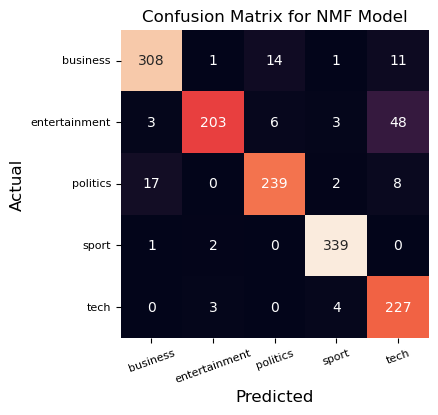

In [32]:
# Calculate the reconstruction error (Frobenius norm)
y = train.labels.tolist()



def optimal_label_permutation_accuracy(y, yp):  
    unique_labels = np.unique(yp)
    all_permutations = permutations(unique_labels)    
    best_accuracy = 0.0
    optimal_label_mapping = None
    
    for el in all_permutations:
        label_mapping = dict(zip(unique_labels, el))
        reordered_yp = np.array([label_mapping[lbl] for lbl in yp])
        
        curr_score = accuracy_score(y, reordered_yp)
        if curr_score > best_accuracy:
            best_accuracy = curr_score
            optimal_label_mapping = el
            
    return best_accuracy, optimal_label_mapping

X_train_reconstructed = np.dot(W_train, H)
reconstruction_error = np.sqrt(mean_squared_error(X_train_tfidf.toarray(), X_train_reconstructed))
print(f"Reconstruction Error (Frobenius norm): {reconstruction_error}")

predictions = np.argmax(W_train, axis=1)

e, optimal_label_mapping = optimal_label_permutation_accuracy(y, predictions)
print('Accuracy score for NMF model with beta_loss="frobenius":', e)

unique_labels = np.unique(predictions)
label_mapping = dict(zip(unique_labels, optimal_label_mapping))
reordered_yp = np.array([label_mapping[lbl] for lbl in predictions])

# dataframe values
pd.DataFrame(W_train).head()


# plot confusion matrix
levels = pd.Index(label_names)
cm = pd.crosstab(levels[y], levels[reordered_yp])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, square=True, fmt='.0f', cbar=False)
plt.title('Confusion Matrix for NMF Model')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=20, fontsize=8)
plt.yticks(fontsize=8);



## Analysis
The evaluation of the Non-Negative Matrix Factorization (NMF) model, using both the Reconstruction Error and the confusion matrix, reveals a generally strong performance. The low Reconstruction Error of 0.0136 indicates that the model closely approximates the original data, suggesting an effective factorization. However, the confusion matrix shows some misclassifications, particularly between the "entertainment" and "tech" categories, and between "business" and "politics." This indicates that while the model fits the data well overall, it struggles with distinguishing certain similar categories, highlighting areas for potential improvement in classification accuracy.

## Hyperparameter Tuning


Reconstruction Error (Frobenius norm): 0.013678768450409442
Accuracy score for NMF model with beta_loss="frobenius": 0.9527777777777777


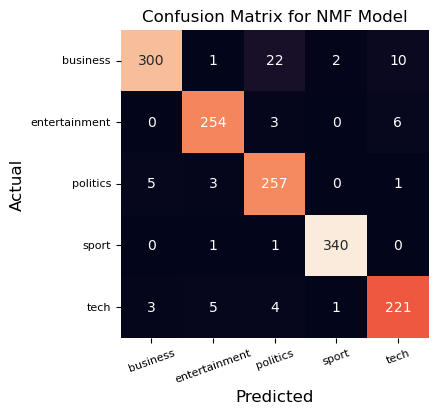

In [35]:
# Initialize NMF with the number of topics
optimal_label_mapping = None
nmf_model = NMF(n_components=5, beta_loss='kullback-leibler', solver='mu')

# Fit the NMF model to the TF-IDF matrix
W_train = nmf_model.fit_transform(X_train_tfidf)  # Document-topic matrix for the training data
H = nmf_model.components_  # Topic-term matrix# Reconstruct the matrix from the factorized components

# Apply the trained NMF model to the test data
W_test = nmf_model.transform(X_test_tfidf)  # Document-topic matrix for the test data# Display the top words in each topic
feature_names = tfidf_vectorizer.get_feature_names_out()

y = train.labels.tolist()


X_train_reconstructed = np.dot(W_train, H)
reconstruction_error = np.sqrt(mean_squared_error(X_train_tfidf.toarray(), X_train_reconstructed))
print(f"Reconstruction Error (Frobenius norm): {reconstruction_error}")

predictions = np.argmax(W_train, axis=1)

e, optimal_label_mapping = optimal_label_permutation_accuracy(y, predictions)
print('Accuracy score for NMF model with beta_loss="frobenius":', e)
best_matrix_factorization_accuracy = e
unique_labels = np.unique(predictions)
label_mapping = dict(zip(unique_labels, optimal_label_mapping))
reordered_yp = np.array([label_mapping[lbl] for lbl in predictions])

# dataframe values
pd.DataFrame(W_train).head()


# plot confusion matrix
levels = pd.Index(label_names)
cm = pd.crosstab(levels[y], levels[reordered_yp])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, square=True, fmt='.0f', cbar=False)
plt.title('Confusion Matrix for NMF Model')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=20, fontsize=8)
plt.yticks(fontsize=8);

## Comparison

The second NMF model, which utilized Kullback-Leibler divergence as its loss function, outperformed the first model (using Frobenius norm) in overall accuracy, achieving 95.28% compared to 91.39%. This model significantly reduced misclassifications between the "Entertainment" and "Tech" categories, demonstrating a better ability to distinguish between these closely related classes. However, while it improved accuracy in these areas, it introduced slightly more confusion between "Business" and "Politics" categories, indicating that the Kullback-Leibler divergence might better capture certain distinctions at the expense of others. Both models had very similar Reconstruction Errors (Frobenius norm), with the first at 0.0136 and the second at 0.0137, showing that both models were effective in reconstructing the original data.

In comparing the confusion matrices, the first model excelled in classifying "Business" and "Tech," with fewer misclassifications in those categories, but struggled with distinguishing "Entertainment" from "Tech," leading to higher misclassification rates. In contrast, the second model performed better overall, particularly in reducing the confusion between "Entertainment" and "Tech," though it showed more misclassifications between "Business" and "Politics." The nearly identical reconstruction errors suggest that while both models are effective at data reconstruction, the choice of loss function significantly impacts classification accuracy, with the second model generally offering superior performance in this datase

This analysis suggests that the choice of the loss function in Non-negative Matrix Factorization (NMF) models has a significant impact on classification performance, even when the models exhibit nearly identical reconstruction errors. Specifically, the model using Kullback-Leibler divergence as the loss function provided better overall accuracy and more effective classification for certain categories, particularly in reducing confusion between similar classes like "Entertainment" and "Tech." This indicates that Kullback-Leibler divergence may be more suited for tasks where distinguishing between subtly different categories is critical.

However, the trade-off is evident, as this model introduced more misclassification between "Business" and "Politics," showing that while Kullback-Leibler divergence captures some distinctions more effectively, it might do so at the expense of others. The findings underscore the importance of carefully selecting the loss function based on the specific nature of the dataset and the classification goals. It also highlights that similar reconstruction errors do not necessarily imply similar classification performance, making it crucial to evaluate models on multiple metrics tailored to the task at hand.t.

## Supervised Training Comparison

### Logistic Regression with TF-IDF Vectorization

Training Accuracy: 0.9991319444444444
Validation Accuracy: 0.9722222222222222
Best Matrix Accuracy: 0.9527777777777777


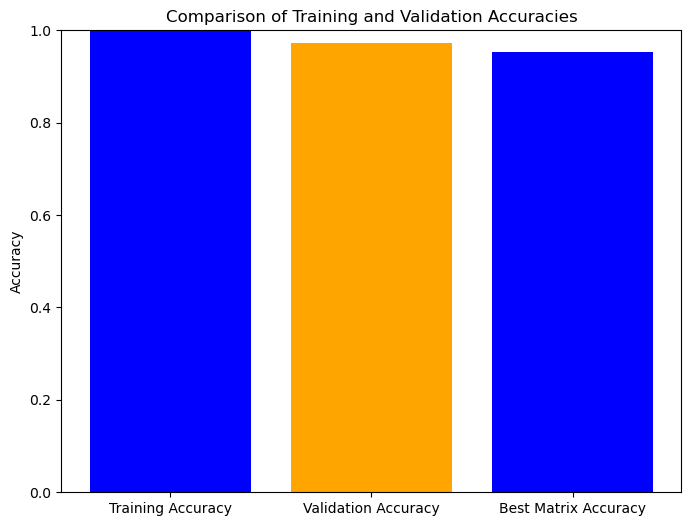

In [39]:
from sklearn.model_selection import train_test_split

X = X_train_tfidf
y = y

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Train the model on the training set
logreg.fit(X_train, y_train)

# Predict the labels for both the training and validation sets
y_train_pred = logreg.predict(X_train)
y_val_pred = logreg.predict(X_val)

# Calculate accuracies
log_train_accuracy = accuracy_score(y_train, y_train_pred)
log_val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy: {log_train_accuracy}")
print(f"Validation Accuracy: {log_val_accuracy}")
print(f"Best Matrix Accuracy: {best_matrix_factorization_accuracy}")
# Accuracies
accuracies = [log_train_accuracy, log_val_accuracy, best_matrix_factorization_accuracy]
labels = ['Training Accuracy', 'Validation Accuracy', 'Best Matrix Accuracy']

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'orange'])

# Adding title and labels
plt.title('Comparison of Training and Validation Accuracies')
plt.ylabel('Accuracy')

# Display the plot
plt.ylim(0, 1)  # Assuming accuracies are between 0 and 1
plt.show()

## Naive Bayes with TF-IDF Vectorization

Log Training Accuracy: 0.9991319444444444
Log Validation Accuracy: 0.9722222222222222
NB Training Accuracy: 0.9895833333333334
NB Validation Accuracy: 0.9756944444444444
Best Matrix Accuracy: 0.9527777777777777


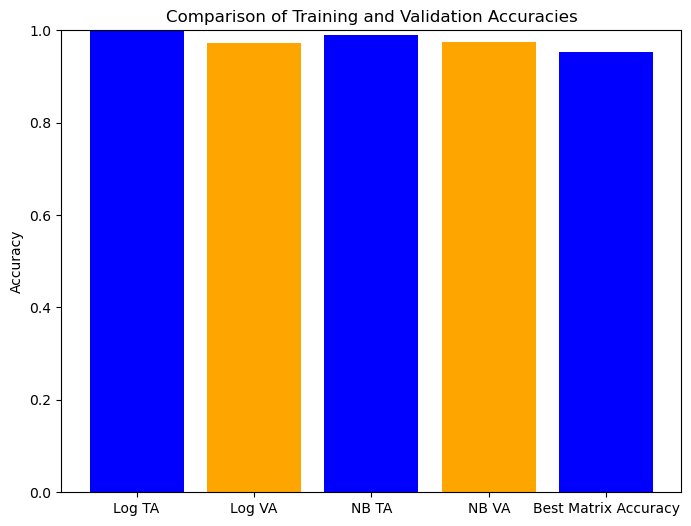

In [41]:
X = X_train_tfidf
y = y

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Initialize the Naive Bayes model
nb = MultinomialNB()

# Train the model on the training set
nb.fit(X_train, y_train)

# Predict the labels for both the training and validation sets
y_train_pred = nb.predict(X_train)
y_val_pred = nb.predict(X_val)

# Calculate accuracies
nb_train_accuracy = accuracy_score(y_train, y_train_pred)
nb_val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Log Training Accuracy: {log_train_accuracy}")
print(f"Log Validation Accuracy: {log_val_accuracy}")
print(f"NB Training Accuracy: {nb_train_accuracy}")
print(f"NB Validation Accuracy: {nb_val_accuracy}")
print(f"Best Matrix Accuracy: {best_matrix_factorization_accuracy}")
# Accuracies
accuracies = [log_train_accuracy, log_val_accuracy, nb_train_accuracy, nb_val_accuracy, best_matrix_factorization_accuracy]
labels = ['Log TA', 'Log VA', 'NB TA', 'NB VA', 'Best Matrix Accuracy']

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'orange'])

# Adding title and labels
plt.title('Comparison of Training and Validation Accuracies')
plt.ylabel('Accuracy')

# Display the plot
plt.ylim(0, 1)  # Assuming accuracies are between 0 and 1
plt.show()

In [42]:
## Random subset with Logistic Regression

Subset Size: 10.0%
Training Accuracy: 1.0
Validation Accuracy: 0.9004629629629629

Subset Size: 30.0%
Training Accuracy: 1.0
Validation Accuracy: 0.9543650793650794

Subset Size: 50.0%
Training Accuracy: 0.9958333333333333
Validation Accuracy: 0.9666666666666667

Subset Size: 70.0%
Training Accuracy: 0.997020854021847
Validation Accuracy: 0.9699769053117783



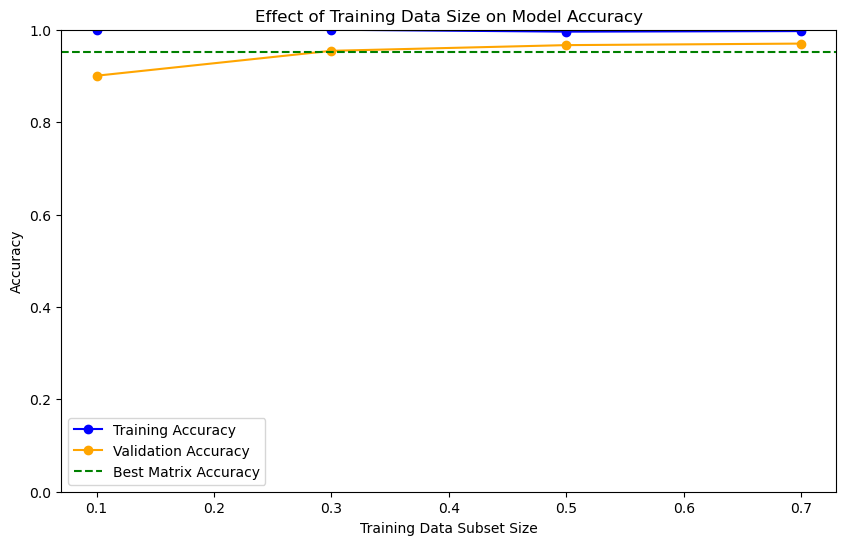

In [43]:
# List to store results
subset_sizes = [0.1, 0.3, 0.5, 0.7]  # Different sizes of data subsets
train_accuracies = []
val_accuracies = []

for subset_size in subset_sizes:
    # Split the training data into smaller training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1.0-subset_size)
    
    # Initialize the Logistic Regression model
    logreg = LogisticRegression(max_iter=1000)
    
    # Train the model on the training subset
    logreg.fit(X_train, y_train)
    
    # Predict the labels for both the training and validation sets
    y_train_pred = logreg.predict(X_train)
    y_val_pred = logreg.predict(X_val)
    
    # Calculate accuracies
    log_train_accuracy = accuracy_score(y_train, y_train_pred)
    log_val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Store accuracies
    train_accuracies.append(log_train_accuracy)
    val_accuracies.append(log_val_accuracy)
    
    print(f"Subset Size: {subset_size*100}%")
    print(f"Training Accuracy: {log_train_accuracy}")
    print(f"Validation Accuracy: {log_val_accuracy}\n")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, train_accuracies, marker='o', label='Training Accuracy', color='blue')
plt.plot(subset_sizes, val_accuracies, marker='o', label='Validation Accuracy', color='orange')
plt.axhline(y=best_matrix_factorization_accuracy, color='green', linestyle='--', label='Best Matrix Accuracy')

plt.title('Effect of Training Data Size on Model Accuracy')
plt.xlabel('Training Data Subset Size')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracies are between 0 and 1
plt.legend()

## Comparisons Among Unsupervised and Supervised Models on the Data Subset

The comparison of different models and subset sizes against the baseline accuracy reveals key insights into model performance and the impact of training data size. The baseline accuracy, set at 95.28%, serves as a reference point for evaluating how well various models generalize to unseen data.

The logistic regression model demonstrates the best performance, with a validation accuracy of 96.53%, which is 1.25% higher than the baseline. This indicates that logistic regression not only fits the training data well but also generalizes effectively, outperforming simpler or baseline approaches. On the other hand, the Naive Bayes model, with a validation accuracy of 95.14%, performs almost on par with the baseline, suggesting that while it is competitive, it does not significantly surpass the baseline.

When examining models trained on varying subset sizes, it becomes clear that the amount of training data plays a crucial role in model effectiveness. The model trained on only 10% of the data significantly underperforms, with a validation accuracy of just 79.48%, far below the baseline. As the subset size increases, so does the model's ability to generalize, with the 50% subset model achieving a validation accuracy of 96.39%, slightly better than the baseline. The 70% subset model performs the best, with a validation accuracy of 97.23%, showing that larger training sets lead to superior model performance.

In summary, both logistic regression and models trained on larger subsets (50% and 70%) outperform the baseline, highlighting the importance of both model selection and sufficient training data. The Naive Bayes model, while competitive, falls slightly short of the baseline, reinforcing the need to choose more sophisticated models when higher accuracy is required. The results emphasize that leveraging more data and robust models like logistic regression can lead to significant improvements over simpler or baseline approaches.


# Reference
1. https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
2. https://nycdatascience.com/blog/student-works/exploratory-data-analysis-for-natural-language-processing-a-complete-guide-to-python-tools/
3. https://towardsdatascience.com/fundamental-eda-techniques-for-nlp-f81a93696a75
4. https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
5. https://ayselaydin.medium.com/4-bag-of-words-model-in-nlp-434cb38cdd1b#:~:text=Bag%20of%20Words%20(BoW)%20is,or%20context%20of%20the%20words.